In [1]:
# default_exp core

# AutoNeuro

> API details.


Normalizing neurological data is near impossible to do at scale.
There are dozens of neurological tests each with a diverse collection of normalizations data.
Due to the fractured nature of the research, this has led to a collection of diverse normalizations schemes.
This package is an attempt to unify these into a single API.


In [2]:
#hide

from nbdev.showdoc import *

In [ ]:
#hide
#export

import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import norm

This will be easiest with an example test.
The BVMT-R is a useful example.
There are multiple measurements for the test Immediate Recall, Delayed Recall, and Recognition.
The values represent the number of cards remembered after different lengths of time.
Here's an example dataset.

In [3]:
bvmt_data = pd.read_csv('data/testing/bvmt.tsv', sep = '\t', na_values=['na'])
bvmt_demo = pd.read_csv('data/testing/bvmt_demo.tsv', sep = '\t', na_values=['na'])
bvmt_all = pd.concat([bvmt_data, bvmt_demo], axis=1)
bvmt_all.tail()

,BVMTform,BVMTtrial1,BVMTtrial2,BVMTtrial3,BVMTimmed,BVMTdelay,BVMTretention,BVMThits,BVMTfalsepos,BVMTrecog,BVMTcopy,Age,Sex,Race,Race_specify,Education,EngFluency,SpanFluency,MMSE
8,1,2.0,4.0,4.0,10.0,4.0,100.0,4.0,1.0,3.0,12.0,47,1,2,NaN,10,3,0,28.0
9,1,2.0,6.0,7.0,15.0,6.0,86.0,5.0,1.0,4.0,12.0,57,1,2,NaN,9,3,0,25.0
10,1,2.0,2.0,4.0,8.0,2.0,50.0,6.0,2.0,4.0,12.0,64,1,2,NaN,16,3,0,26.0
11,1,3.0,6.0,7.0,16.0,7.0,100.0,6.0,0.0,6.0,11.0,45,2,2,NaN,10,3,0,29.0
12,1,3.0,6.0,3.0,12.0,3.0,50.0,5.0,0.0,5.0,11.0,73,1,2,NaN,10,3,0,29.0


Our goal is to transform this data utilizing a collection of known normalization schemes.
We will adapt the sklearn API to perform these tasks.
This will allow us to use the vast array of other tools in the sklearn ecosystem.

Let's start by using a lookup table style normalization scheme.
This lookup table provides the mean and std of a "healthy" population on the same test.

,MinAge,MaxAge,Total,Total-STD,Learn,Learn-STD,DR,DR-STD,ret,ret-STD,Disc,Disc-STD
0,18,21,28.74,4.32,3.63,1.67,10.79,1.37,95.34,6.60,5.91,0.31
1,20,23,28.44,4.38,3.64,1.68,10.68,1.41,94.93,7.26,5.92,0.26
2,24,25,27.83,4.48,3.65,1.69,10.46,1.48,95.08,8.04,5.89,0.30
3,26,29,27.52,4.54,3.66,1.70,10.35,1.52,96.67,6.31,5.97,0.15
4,30,33,26.92,4.64,3.67,1.71,10.13,1.60,96.20,4.74,5.97,0.15


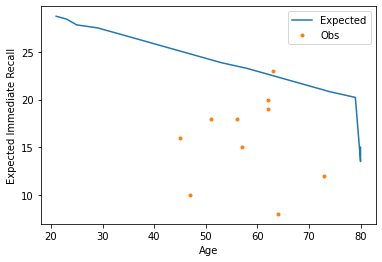

In [4]:
bvmt_norm = pd.read_csv('data/testing/bvmtr_extract.csv')
ax = bvmt_norm.plot(x = 'MaxAge', y = 'Total', label = 'Expected')
bvmt_all.plot(x = 'Age', y = 'BVMTimmed', ax=ax, label = 'Obs',
              marker = '.', linestyle = '')
ax.set_ylabel('Expected Immediate Recall')
bvmt_norm.head()

As expected, the average expected number of cards recalled goes down with age (blue line).
The plotted points mostly fall below this line, indicating that they are performing worse compared to age-matched controls.
Let's use a transformer to correct for these problems.

In [16]:
#export
#hide

FILTER_MAPPINGS = {'gt': '>',
                   'gte': '>=',
                   'lte': '<=',
                   'lt': '<',
                   'eq': '--',
                   'neq': '!='}



def _build_filters(lookup_table):
    """
    Build filters from lookup table
    Parameters
    ----------
    lookup_table : pd.DataFrame

    Returns
    -------

    """


    filts = dict((_id, []) for _id in lookup_table.index)
    expected = set()
    for col in lookup_table.columns:
        if '__' in col:
            field, nop = col.split('__')
            op = FILTER_MAPPINGS.get(nop, None)
            if op is not None:
                expected.add(field)
                for ind, val in lookup_table[col].to_dict().items():
                    if type(val) == str:
                        filts[ind].append(f'({field} {op} "{val}")')
                    else:
                        filts[ind].append(f'({field} {op} {val})')
    return pd.Series([' & '.join(filts[ind]) for ind in lookup_table.index],
                     index = lookup_table.index), sorted(expected)

def _build_lookup_norms(lookup_table):
    """

    Pulls out the values of the __mean and __std columns to create a
    pd.Series of scipy.norm instances.

    This can be better generalized in the future.

    Parameters
    ----------
    lookup_table : pd.DataFrame

    Returns
    -------
    ps.Series
    """

    mean_col = next(col for col in lookup_table.columns if col.endswith('__mean'))
    std_col = next(col for col in lookup_table.columns if col.endswith('__std'))

    field = mean_col.split('__')[0]

    return mean_col, std_col, field



    norm_list = []
    for _, row in lookup_table.iterrows():
        norm_list.append(norm(loc = row[mean_col],
                               scale = row[std_col]))
    return pd.Series(norm_list, index = lookup_table.index), fields




class LookupNormalTransform(BaseEstimator, TransformerMixin):

    def __init__(self, lookup_table=None, name = ''):
        """

        Parameters
        ----------
        lookup_table : pd.DataFrame
          Formatted lookup-table for the transformer
        """
        super(LookupNormalTransform, self).__init__()


        self.lookup_table = lookup_table
        self.name = name


    def fit(self, *args, **kwargs):
        self._filters, self._filter_cols = _build_filters(self.lookup_table)
        self._mean_col, self._std_col, self._measure_col = _build_lookup_norms(self.lookup_table)
        return self

    @property
    def needed_cols(self):
        return self._filter_cols + [self._measure_col]

    def get_feature_names(self):
        return [self.name]

    def match_samples(self, data, keep = 'last'):
        
        linker_func = lambda flt: data.query(flt).index
        all_matches = self._filters.map(linker_func)
        
        data2flt = {}
        for num, matches in all_matches.to_dict().items():
            for d_ind in matches:
                data2flt[d_ind] = num
        data2flt = pd.Series(data2flt)
        return data2flt.reindex(data.index)


    def normalize_samples(self, data, matched_rows = None):

        if matched_rows is None: matched_rows = self.match_samples(data)

        valid_matches = matched_rows.dropna()
        obs_vals = data.loc[valid_matches.index, self._measure_col]
        means = self.lookup_table.loc[valid_matches.values, self._mean_col]
        stds = self.lookup_table.loc[valid_matches.values, self._std_col]
        Zs = pd.Series((obs_vals.values-means.values)/stds.values,
                       valid_matches.index,
                       name = self.name)

        return Zs.reindex(data.index)


    def transform(self, data):

        return pd.DataFrame(self.normalize_samples(data))








We will need to re-arrange the normalization table into a more suitable format.
This uses __ to indicate operations based on a currently limited language.
These need to map to the same columns as the input data.

In [17]:
mapping = {'MinAge':'Age__gte',
           'MaxAge':'Age__lte',
           'Total': 'BVMTimmed__mean',
           'Total-STD': 'BVMTimmed__std',
           }
immed_extracted_norm = bvmt_norm.rename(columns = mapping)[mapping.values()]
immed_extracted_norm.head()

,Age__gte,Age__lte,BVMTimmed__mean,BVMTimmed__std
0,18,21,28.74,4.32
1,20,23,28.44,4.38
2,24,25,27.83,4.48
3,26,29,27.52,4.54
4,30,33,26.92,4.64


In [18]:
transform_immed = LookupNormalTransform(immed_extracted_norm,
                                  name = 'BVMTimmed-lookup').fit()

# You can extract the index of matched samples
hits = transform_immed.match_samples(bvmt_all)

# Or transform into normalized Z-scores directly
z_scores_immed = transform_immed.normalize_samples(bvmt_all)
z_scores_immed = transform_immed.transform(bvmt_all)

In [19]:
mapping = {'MinAge':'Age__gte',
           'MaxAge':'Age__lte',
           'DR': 'BVMTdelay__mean',
           'DR-STD': 'BVMTdelay__std',
           }
dr_extracted_norm = bvmt_norm.rename(columns = mapping)[mapping.values()]
dr_extracted_norm

transform_dr = LookupNormalTransform(dr_extracted_norm,
                                  name = 'BVMTdelay-lookup').fit()



transform_immed.needed_cols

['Age', 'BVMTimmed']

In [20]:
from sklearn.compose import ColumnTransformer

multi_trans = ColumnTransformer([('bvmt_immid_lookup', transform_immed, transform_immed.needed_cols),
                                 ('bvmt_delay_lookup', transform_dr, transform_dr.needed_cols )])

multi_trans.fit_transform(bvmt_all)

array([[        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [-0.67903525, -1.21596244],
       [-0.49350649, -1.21596244],
       [-0.99810606, -0.88292683],
       [-1.13320463,         nan],
       [ 0.17272727, -0.62272727],
       [-2.85601578, -2.76315789],
       [-1.56628788, -1.37073171],
       [-2.55454545, -2.89545455],
       [-1.83266129, -1.34972678],
       [-1.54640981, -2.08898305]])

In [22]:
multi_trans.get_feature_names()


['bvmt_immid_lookup__BVMTimmed-lookup', 'bvmt_delay_lookup__BVMTdelay-lookup']